# EXIST 2021 - BERT tunning <a class="anchor" id="bert-tunning"></a>

    ÁLVARO FAUBEL SANCHIS
    CLARA MARTÍ TORREGROSA

#####  Table of contents :
- [Requiered functions](#functions)
 * [Required libraries and configuration](#libraries)
 * [Train, Val, Test split](#split)
 * [Cleaning](#cleaning)
 * [BERT](#bert)
     
- [EXIST Task](#exist)
 * [Data load](#data-load)
 * [Fine Tunning Models](#fine-tunning)
     - [Spanish](#tunning-sp)
         - [Task 1](#sp-t1)
         - [Task 2](#sp-t2)
     - [English](#tunning-en)
         - [Task 1](#en-t1)
         - [Task 2](#en-t2)



---

### Requiered functions <a class="anchor" id="functions"></a>

#### Required libraries and configuration <a class="anchor" id="libraries"></a>

In [ ]:
# Data & visualization
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt

# Pytoch 
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence

# BERT Hugging Face
import transformers
from transformers import BertModel, BertTokenizer, AutoTokenizer, AutoModel
from transformers import  AdamW, get_linear_schedule_with_warmup

# Sklearn: methods & metrics 
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Configuration: seed & display
RANDOM_SEED = 45
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####  Train, val, test split <a class="anchor" id="split"></a>

In [2]:
def data_split(df, size = 0.1, stratify = None, seed = RANDOM_SEED):
    if stratify != None:
        df_train, df_test = train_test_split(df, test_size=size, random_state=seed, stratify=df[stratify])
        df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=seed, stratify=df_test[stratify])
    else:
        df_train, df_test = train_test_split(df, test_size=size, random_state=seed)
        df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=seed)
    return df_train, df_val, df_test

#### Cleaning (optional) <a class="anchor" id="cleaning"></a>

In [3]:
import preprocessor as p
import re

emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  
                            u"\U0001F300-\U0001F5FF"  
                            u"\U0001F680-\U0001F6FF"  
                            u"\U0001F1E0-\U0001F1FF"  
                            "]+", flags=re.UNICODE)

def clean_tweet(tweet, special_tokens = True, emoji_pattern = emoji_pattern):
    if special_tokens:
        text_clean = p.tokenize(tweet)
    else:
        text_clean = p.clean(tweet)
    text_clean_emoji = emoji_pattern.sub(r'', text_clean)
    return text_clean_emoji

#### BERT <a class="anchor" id="bert"></a>

*  Plot the chosen pre-trained tokenizer distribution

In [4]:
def plot_tokens_distrib(df, column, tokenizer):
    token_lens = []
    for i, txt in enumerate(df[column]):
        tokens = tokenizer.encode(txt)
        token_lens.append(len(tokens))
    sns.displot(token_lens)
    plt.xlabel('Token count');

* Class for structure the data

In [5]:
class TweetsDataset(Dataset):
    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(tweet,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt')
    
        return {'tweet_text': tweet,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

* Creation of data loaders objects for the segmentation in packets (batch)

In [6]:
def create_data_loader(df, column, target, tokenizer, max_len, batch_size):
    ds = TweetsDataset(tweets=df[column].to_numpy(),
                       targets=df[target].to_numpy(),
                       tokenizer=tokenizer,
                       max_len=max_len)
    return DataLoader(ds, batch_size=batch_size, num_workers=0)

* Custom classifiers from pre-trained BERT model

In [7]:
class BERTClassifier(nn.Module):
    def __init__(self, n_classes, model_name):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.1)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        last_hidden_states = self.bert(input_ids=input_ids,
                                       attention_mask=attention_mask, return_dict=False)
        output = self.drop(last_hidden_states[0][:,0,:])
        return self.out(output)

In [8]:
class BERTClassifier2(nn.Module):
    def __init__(self, n_classes, model_name):
        super(BERTClassifier2, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name) 
        self.dropout = nn.Dropout(0.1)
        self.relu =  nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,n_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_ids, attention_mask):
        _,cls_hs = self.bert(input_ids, attention_mask=attention_mask, return_dict=False)   
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

* Optimizer and planner

In [10]:
def create_op_sch(model, data_loader, epochs, lr=1e-5, eps=1e-8):
    optimizer = AdamW(model.parameters(), lr=lr, eps=eps, correct_bias=False)
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(data_loader) * epochs)
    return optimizer, scheduler

* Class weights and loss function

In [11]:
def calc_class_weigths(df, target):
    weights = compute_class_weight('balanced', np.unique(df[target]), df[target])
    return torch.FloatTensor(weights)

In [12]:
def get_loss_function(weights = None):
    if weights != None:
        loss_fn = nn.CrossEntropyLoss(weight=weights)
    else:
        loss_fn = nn.CrossEntropyLoss()
    return loss_fn

* One-stage training and model evaluation function

In [13]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        #probabilities = torch.nn.functional.softmax(outputs, dim=1)
        #preds = (probabilities[:,1] > 0.75).float()
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [14]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            #probabilities = torch.nn.functional.softmax(outputs, dim=1)
            #preds = (probabilities[:,1] > 0.75).float()
            
            _, preds = torch.max(outputs, dim=1)
            
            loss = loss_fn(outputs, targets)
        
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

* Training and validation loop

In [15]:
def train_eval_model(model, data_dic, tools_dic, epochs, name_model, device=device):

    history = defaultdict(list)
    best_accuracy, best_loss = 0, 100
    
    train_data_loader = data_dic['train_data_loader']
    val_data_loader = data_dic['val_data_loader']
    
    df_train = data_dic['df_train']
    df_val = data_dic['df_val']
    
    loss_fn = tools_dic['loss_fn']
    optimizer = tools_dic['optimizer']
    scheduler = tools_dic['scheduler']

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(model,
                                            train_data_loader,
                                            loss_fn,    
                                            optimizer,
                                            device,
                                            scheduler,
                                            len(df_train))

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(model,
                                       val_data_loader, 
                                       loss_fn, 
                                       device, 
                                       len(df_val))

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc >= best_accuracy: 
            torch.save(model.state_dict(), '../Models/{}.bin'.format(name_model))
            best_accuracy = val_acc

        #if epoch + 1 == 10:
        #    torch.save(model.state_dict(), 'best_model_state.bin')

* Get the predictions

In [16]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    tweets_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
  
    with torch.no_grad():
        for d in data_loader:
            
            texts = d["tweet_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            #probabilities = torch.nn.functional.softmax(outputs, dim=1)
            #preds = (probabilities[:,1] > 0.7).float()
            
            _, preds = torch.max(outputs, dim=1)
            
            tweets_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return tweets_texts, predictions, prediction_probs, real_values

---

# EXIST Task <a class="anchor" id="exist"></a>

## Data load <a class="anchor" id="data-load"></a>

#### Train data

In [17]:
df = pd.read_csv('../EXIST2021_dataset/training/EXIST2021_training.tsv', sep='\t')
df['task1_encoding'] = df['task1'].replace({'sexist': 1, 'non-sexist':  0})      # Codificamos la variable a numérica

df.head()

,test_case,id,source,language,text,task1,task2,task1_encoding
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality,1
1,EXIST2021,2,twitter,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist,0
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification,1
3,EXIST2021,4,twitter,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist,non-sexist,0
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist,0


* Separated a set with only the sexist tweets for task 2

In [18]:
df_t2 = df.drop(df.loc[df['task1']=='non-sexist'].index)
df_t2['task2_encoding'] = df_t2['task2'].replace({'ideological-inequality' : 0,
                                                  'stereotyping-dominance' : 1, 'misogyny-non-sexual-violence': 2,
                                                  'sexual-violence' : 3, 'objectification': 4})
df_t2.head()

,test_case,id,source,language,text,task1,task2,task1_encoding,task2_encoding
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality,1,0
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification,1,4
5,EXIST2021,6,twitter,en,@Smithcouple971 Hello....m raj....m with good ...,sexist,sexual-violence,1,3
10,EXIST2021,11,twitter,en,@hapyshoper79 @Dis_Critic @MairiJCam @cazadams...,sexist,ideological-inequality,1,0
15,EXIST2021,16,twitter,en,@Ponderer_O_Purg @BynameRose @GameOverRos @nat...,sexist,ideological-inequality,1,0


* Split the datasets into spanish and english

In [19]:
df_es = df[df['language'] == 'es']
df_en = df[df['language'] == 'en']

df_t2_es = df_t2[df_t2['language'] == 'es']
df_t2_en = df_t2[df_t2['language'] == 'en']

---

# Fine tunning <a class="anchor" id="fine-tunning"></a>

## Fine tunning models Spanish <a class="anchor" id="tunning-sp"></a>

#### Task1 <a class="anchor" id="sp-t1"></a>

In [20]:
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.RESERVED) #, p.OPT.HASHTAG p.OPT.NUMBER)

df_es['text_clean'] = [clean_tweet(tw, special_tokens=True) for tw in df_es.text]

<ipython-input-20-cf9e4adac03e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_es['text_clean'] = [clean_tweet(tw, special_tokens=True) for tw in df_es.text]


* We divide the train dataset in English into train, val and test

In [21]:
df_train_es1, df_val_es1, df_test_es1 = data_split(df_es, stratify='task1_encoding')
df_train_es1.shape, df_val_es1.shape, df_test_es1.shape

((3186, 9), (177, 9), (178, 9))

* Choose the pre-trained BERT model and see the length distribution of the tokenized tweets

In [24]:
PRE_TRAINED_MODEL_NAME_ES1 = 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer_es1 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_ES1)

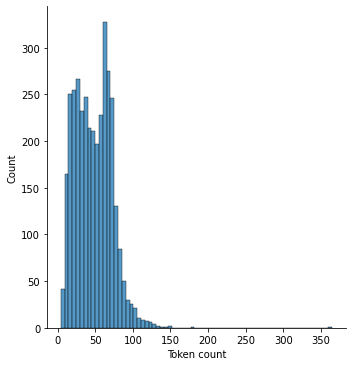

In [25]:
plot_tokens_distrib(df_es, 'text_clean', tokenizer_es1)

* Set a maximum length based on the previous results

In [26]:
MAX_LEN_ES1 = 155

* Create the data_loader with a chosen batch size

In [27]:
BATCH_SIZE_ES1 = 16

train_data_loader_es1 = create_data_loader(df_train_es1, 'text_clean', 'task1_encoding', tokenizer_es1, MAX_LEN_ES1, BATCH_SIZE_ES1)
val_data_loader_es1 = create_data_loader(df_val_es1, 'text_clean', 'task1_encoding', tokenizer_es1, MAX_LEN_ES1, BATCH_SIZE_ES1)
test_data_loader_es1 = create_data_loader(df_test_es1, 'text_clean', 'task1_encoding', tokenizer_es1, MAX_LEN_ES1, BATCH_SIZE_ES1)

* Define the bert model with two classes

In [28]:
model_es1 = BERTClassifier2(2, PRE_TRAINED_MODEL_NAME_ES1)
model_es1 = model_es1.to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* Define the number of learning stages and obtain the optimizer, planner and the necessary loss function

In [29]:
EPOCHS_ES1 = 10

optimizer_es1, scheduler_es1 = create_op_sch(model_es1, train_data_loader_es1, EPOCHS_ES1)
loss_fn_es1 = get_loss_function().to(device)

#loss_fn_es1 = nn.NLLLoss() 

* Put the data and necessary objects for the training of the model in dictionaries

In [30]:
data_dic_es1 = {'train_data_loader': train_data_loader_es1,
                'val_data_loader': val_data_loader_es1,
                'df_train': df_train_es1,
                'df_val': df_val_es1}

tools_dic_es1 = {'loss_fn': loss_fn_es1,
                 'optimizer': optimizer_es1,
                 'scheduler': scheduler_es1}

* Train the model

In [31]:
%%time
train_eval_model(model_es1, data_dic_es1, tools_dic_es1, EPOCHS_ES1, 'task1_spanish')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1/10
----------


c:\python\python39\lib\site-packages\transformers\tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 0.5633366690576076 accuracy 0.7052730696798494
Val   loss 0.6021323055028915 accuracy 0.7005649717514124

Epoch 2/10
----------
Train loss 0.35106835022568705 accuracy 0.8615819209039549
Val   loss 0.7105737378199896 accuracy 0.751412429378531

Epoch 3/10
----------
Train loss 0.21216464810073377 accuracy 0.9337727558066542
Val   loss 1.056621586283048 accuracy 0.7401129943502824

Epoch 4/10
----------
Train loss 0.14335405827732756 accuracy 0.9588826114249843
Val   loss 1.1656143392125766 accuracy 0.768361581920904

Epoch 5/10
----------
Train loss 0.09306970047880896 accuracy 0.9742623979912116
Val   loss 1.3337407757838566 accuracy 0.7627118644067796

Epoch 6/10
----------
Train loss 0.059764649014687164 accuracy 0.9833647206528563
Val   loss 1.5437449390689533 accuracy 0.751412429378531

Epoch 7/10
----------
Train loss 0.043973578558652665 accuracy 0.9908976773383554
Val   loss 1.797756351530552 accuracy 0.7288135593220338

Epoch 8/10
----------
Train loss 0.03575340129

* Test and validate the model on the test subset

In [33]:
model_es1 = BERTClassifier2(2, PRE_TRAINED_MODEL_NAME_ES1)
model_es1.load_state_dict(torch.load('../Models/task1_spanish.bin'))
model_es1 = model_es1.to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
y_tweets_es1, y_pred_es1, y_pred_probs_es1, y_test_es1 = get_predictions(model_es1, test_data_loader_es1)

In [35]:
print(classification_report(y_test_es1, y_pred_es1))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        90
           1       0.80      0.89      0.84        88

    accuracy                           0.84       178
   macro avg       0.84      0.84      0.84       178
weighted avg       0.84      0.84      0.84       178



In [36]:
torch.cuda.empty_cache()

---

#### Task2 <a class="anchor" id="sp-t2"></a>

In [22]:
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.RESERVED) #, p.OPT.HASHTAG p.OPT.NUMBER)

df_t2_es['text_clean'] = [clean_tweet(tw, special_tokens=True) for tw in df_t2_es.text]

<ipython-input-22-1bc8e9d6bd4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t2_es['text_clean'] = [clean_tweet(tw, special_tokens=True) for tw in df_t2_es.text]


* Split the train dataset in English into train, val and test

In [23]:
df_train_es2, df_val_es2, df_test_es2 = data_split(df_t2_es)
df_train_es2.shape, df_val_es2.shape, df_test_es2.shape

((1566, 10), (87, 10), (88, 10))

* Choose the pre-trained BERT model and see the length distribution of the tokenized tweets

In [24]:
PRE_TRAINED_MODEL_NAME_ES2 = 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer_es2 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_ES2)

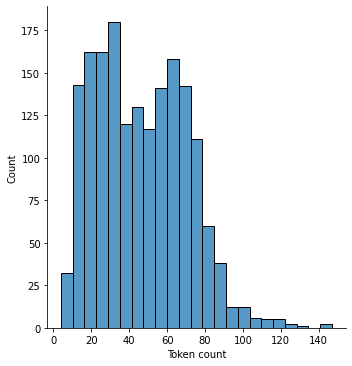

In [25]:
plot_tokens_distrib(df_t2_es, 'text_clean', tokenizer_es2)

* Set a maximum length based on the previous results

In [26]:
MAX_LEN_ES2 = 120

* Create the data_loader with a chosen batch size

In [27]:
BATCH_SIZE_ES2 = 16

train_data_loader_es2 = create_data_loader(df_train_es2, 'text_clean', 'task2_encoding', tokenizer_es2, MAX_LEN_ES2, BATCH_SIZE_ES2)
val_data_loader_es2 = create_data_loader(df_val_es2, 'text_clean', 'task2_encoding', tokenizer_es2, MAX_LEN_ES2, BATCH_SIZE_ES2)
test_data_loader_es2 = create_data_loader(df_test_es2, 'text_clean', 'task2_encoding', tokenizer_es2, MAX_LEN_ES2, BATCH_SIZE_ES2)

* Define the bert model with five classes

In [28]:
model_es2 = BERTClassifier2(5, PRE_TRAINED_MODEL_NAME_ES2)
model_es2 = model_es2.to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* Define the number of learning stages and obtain the necessary optimizer, planner and loss function

In [32]:
EPOCHS_ES2 = 10

optimizer_es2, scheduler_es2 = create_op_sch(model_es2, train_data_loader_es2, EPOCHS_ES2)
#loss_fn_es2 = get_loss_function().to(device)
loss_fn_es2 = get_loss_function(torch.FloatTensor([0.73, 0.8, 0.9, 2, 1.4])).to(device)

* Put the data and necessary objects for the training of the model in dictionaries

In [33]:
data_dic_es2 = {'train_data_loader': train_data_loader_es2,
                'val_data_loader': val_data_loader_es2,
                'df_train': df_train_es2,
                'df_val': df_val_es2}

tools_dic_es2 = {'loss_fn': loss_fn_es2,
                 'optimizer': optimizer_es2,
                 'scheduler': scheduler_es2}

* Train the model

In [34]:
%%time
train_eval_model(model_es2, data_dic_es2, tools_dic_es2, EPOCHS_ES2, 'task2_spanish')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1/10
----------


c:\python\python39\lib\site-packages\transformers\tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.206607527270609 accuracy 0.5287356321839081
Val   loss 0.9404509862263998 accuracy 0.632183908045977

Epoch 2/10
----------
Train loss 0.6993424317666462 accuracy 0.7579821200510856
Val   loss 0.9232983589172363 accuracy 0.6436781609195402

Epoch 3/10
----------
Train loss 0.41361049805976907 accuracy 0.8659003831417625
Val   loss 0.940850963195165 accuracy 0.6781609195402298

Epoch 4/10
----------
Train loss 0.26231602864453984 accuracy 0.9265644955300129
Val   loss 1.170370360215505 accuracy 0.6666666666666666

Epoch 5/10
----------
Train loss 0.1671185051376114 accuracy 0.9559386973180077
Val   loss 1.266593724489212 accuracy 0.6896551724137931

Epoch 6/10
----------
Train loss 0.1113760323757876 accuracy 0.9699872286079183
Val   loss 1.349612255891164 accuracy 0.6666666666666666

Epoch 7/10
----------
Train loss 0.0847315567032415 accuracy 0.9814814814814815
Val   loss 1.661484162012736 accuracy 0.6091954022988506

Epoch 8/10
----------
Train loss 0.06483172475151261 a

* Test and validate the model on the test subset

In [39]:
model_es2 = BERTClassifier2(5, PRE_TRAINED_MODEL_NAME_ES2)
model_es2.load_state_dict(torch.load('../Models/task2_spanish.bin'))
model_es2 = model_es2.to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
y_tweets_es2, y_pred_es2, y_pred_probs_es2, y_test_es2 = get_predictions(model_es2, test_data_loader_es2)

c:\python\python39\lib\site-packages\transformers\tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [41]:
print(classification_report(y_test_es2, y_pred_es2))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.79      0.76      0.77        29
           2       0.62      0.79      0.70        19
           3       0.75      0.50      0.60        12
           4       0.60      0.75      0.67         8

    accuracy                           0.73        88
   macro avg       0.72      0.71      0.71        88
weighted avg       0.74      0.73      0.73        88



In [37]:
torch.cuda.empty_cache()

---

### Fine tunning models English <a class="anchor" id="tunning-en"></a>

#### Task1 <a class="anchor" id="en-t1"></a>

In [20]:
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.RESERVED, p.OPT.HASHTAG, p.OPT.NUMBER)
df_en['text_clean'] = [clean_tweet(tw, special_tokens=True) for tw in df_en.text]

<ipython-input-20-10a68f95080b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['text_clean'] = [clean_tweet(tw, special_tokens=True) for tw in df_en.text]


* Split the train dataset in English into train, val and test

In [21]:
df_train_en1, df_val_en1, df_test_en1 = data_split(df_en, stratify='task1_encoding')
df_train_en1.shape, df_val_en1.shape, df_test_en1.shape

((3092, 9), (172, 9), (172, 9))

* Choose the pre-trained BERT model and see the length distribution of the tokenized tweets

In [22]:
#PRE_TRAINED_MODEL_NAME_EN1 = 'vinai/bertweet-base'
PRE_TRAINED_MODEL_NAME_EN1 = 'cardiffnlp/twitter-roberta-base'

#tokenizer_en1 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_EN1, normalization = True, use_fast = True)
tokenizer_en1 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_EN1)

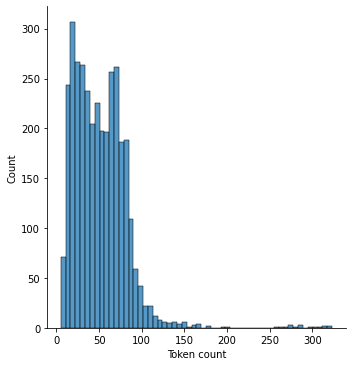

In [23]:
plot_tokens_distrib(df_en, 'text_clean', tokenizer_en1)

* Set a maximum length based on the previous results

In [24]:
MAX_LEN_EN1 = 170

* Create the data_loader with a chosen batch size

In [25]:
BATCH_SIZE_EN1 = 8

train_data_loader_en1 = create_data_loader(df_train_en1, 'text_clean', 'task1_encoding', tokenizer_en1, MAX_LEN_EN1, BATCH_SIZE_EN1)
val_data_loader_en1 = create_data_loader(df_val_en1, 'text_clean', 'task1_encoding', tokenizer_en1, MAX_LEN_EN1, BATCH_SIZE_EN1)
test_data_loader_en1 = create_data_loader(df_test_en1, 'text_clean', 'task1_encoding', tokenizer_en1, MAX_LEN_EN1, BATCH_SIZE_EN1)

* Define the BERT model with two classes

In [26]:
model_en1 = BERTClassifier2(2, PRE_TRAINED_MODEL_NAME_EN1)
model_en1 = model_en1.to(device)

* Define the number of learning stages and obtain the necessary optimizer, planner and loss function

In [27]:
EPOCHS_EN1 = 10

optimizer_en1, scheduler_en1 = create_op_sch(model_en1, train_data_loader_en1, EPOCHS_EN1)
#class_weigths = calc_class_weigths(df_en, 'task1')
#loss_fn_en1 = get_loss_function(weights=class_weigths).to(device)
loss_fn_en1 = get_loss_function().to(device)

* Put the data and necessary objects for the training of the model in dictionaries

In [28]:
data_dic_en1 = {'train_data_loader': train_data_loader_en1,
                'val_data_loader': val_data_loader_en1,
                'df_train': df_train_en1,
                'df_val': df_val_en1}

tools_dic_en1 = {'loss_fn': loss_fn_en1,
                 'optimizer': optimizer_en1,
                 'scheduler': scheduler_en1}

* Train the model

In [30]:
%%time
train_eval_model(model_en1, data_dic_en1, tools_dic_en1, EPOCHS_EN1, 'task1_english')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1/10
----------


c:\python\python39\lib\site-packages\transformers\tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 0.5932536664390072 accuracy 0.6982535575679173
Val   loss 0.4833324985070662 accuracy 0.7674418604651163

Epoch 2/10
----------
Train loss 0.4310253822465533 accuracy 0.8082147477360933
Val   loss 0.492377680811015 accuracy 0.7790697674418604

Epoch 3/10
----------
Train loss 0.3136138118534666 accuracy 0.8800129366106081
Val   loss 0.6518577432090585 accuracy 0.7441860465116279

Epoch 4/10
----------
Train loss 0.23917592614505095 accuracy 0.9184993531694696
Val   loss 0.6781427453864705 accuracy 0.7848837209302325

Epoch 5/10
----------
Train loss 0.19425598562685484 accuracy 0.9427554980595085
Val   loss 0.7623537562110207 accuracy 0.8023255813953488

Epoch 6/10
----------
Train loss 0.14986794634443737 accuracy 0.9573091849935318
Val   loss 0.7976913885636763 accuracy 0.8023255813953488

Epoch 7/10
----------
Train loss 0.12610801618747874 accuracy 0.9650711513583442
Val   loss 0.8509427309036255 accuracy 0.8023255813953488

Epoch 8/10
----------
Train loss 0.11095283136

* Test and validate the model on the test subset

In [30]:
model_en1 = BERTClassifier2(2, PRE_TRAINED_MODEL_NAME_EN1)
model_en1.load_state_dict(torch.load('../Models/task1_english.bin'))
model_en1 = model_en1.to(device)

In [31]:
y_tweets_en1, y_pred_en1, y_pred_probs_en1, y_test_en1 = get_predictions(model_en1, test_data_loader_en1)

In [ ]:
print(classification_report(y_test_en1, y_pred_en1))

In [33]:
print(classification_report(y_test_en1, y_pred_en1))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82        90
           1       0.78      0.88      0.83        82

    accuracy                           0.83       172
   macro avg       0.83      0.83      0.83       172
weighted avg       0.83      0.83      0.83       172



In [51]:
torch.cuda.empty_cache()

---

#### Task2 <a class="anchor" id="en-t2"></a>

In [21]:
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.RESERVED, p.OPT.HASHTAG, p.OPT.NUMBER)
df_t2_en['text_clean'] = [clean_tweet(tw, special_tokens=True) for tw in df_t2_en.text]

<ipython-input-21-3ca45dfc2ad1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t2_en['text_clean'] = [clean_tweet(tw, special_tokens=True) for tw in df_t2_en.text]


* Split the train dataset in English into train, val and test

In [22]:
df_train_en2, df_val_en2, df_test_en2 = data_split(df_t2_en)
df_train_en2.shape, df_val_en2.shape, df_test_en2.shape

((1472, 10), (82, 10), (82, 10))

* Choose the pre-trained BERT model and see the length distribution of the tokenized tweets

In [24]:
#PRE_TRAINED_MODEL_NAME_EN2 = 'vinai/bertweet-base'
PRE_TRAINED_MODEL_NAME_EN2 = 'cardiffnlp/twitter-roberta-base'

#tokenizer_en2 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_EN2, normalization = False, use_fast = False)
tokenizer_en2 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_EN2)

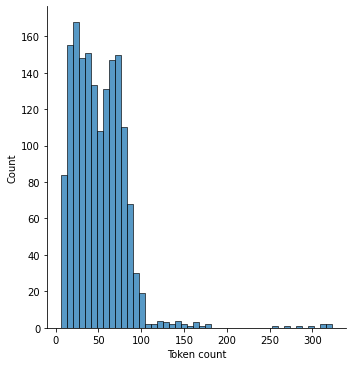

In [25]:
plot_tokens_distrib(df_t2_en, 'text_clean', tokenizer_en2)

* Set a maximum length based on the previous results

In [26]:
MAX_LEN_EN2 = 170

* Create the data_loader with a chosen batch size

In [27]:
BATCH_SIZE_EN2 = 16

train_data_loader_en2 = create_data_loader(df_train_en2, 'text_clean', 'task2_encoding', tokenizer_en2, MAX_LEN_EN2, BATCH_SIZE_EN2)
val_data_loader_en2 = create_data_loader(df_val_en2, 'text_clean', 'task2_encoding', tokenizer_en2, MAX_LEN_EN2, BATCH_SIZE_EN2)
test_data_loader_en2 = create_data_loader(df_test_en2, 'text_clean', 'task2_encoding', tokenizer_en2, MAX_LEN_EN2, BATCH_SIZE_EN2)

* Define the BERT model with five classes

In [28]:
model_en2 = BERTClassifier2(5, PRE_TRAINED_MODEL_NAME_EN2)
model_en2 = model_en2.to(device)

* Define the number of learning stages and obtain the necessary optimizer, planner and loss function

In [29]:
EPOCHS_EN2 = 10

optimizer_en2, scheduler_en2 = create_op_sch(model_en2, train_data_loader_en2, EPOCHS_EN2)
#loss_fn_en2 = get_loss_function(calc_class_weigths(df_t2_en, 'task2_encoding')).to(device)
loss_fn_en2 = get_loss_function(torch.FloatTensor([0.85, 0.9, 10, 1, 1.3])).to(device)

* Put the data and necessary objects for the training of the model in dictionaries

In [30]:
data_dic_en2 = {'train_data_loader': train_data_loader_en2,
                'val_data_loader': val_data_loader_en2,
                'df_train': df_train_en2,
                'df_val': df_val_en2}

tools_dic_en2 = {'loss_fn': loss_fn_en2,
                 'optimizer': optimizer_en2,
                 'scheduler': scheduler_en2}

* Train the model

In [29]:
%%time
train_eval_model(model_en2, data_dic_en2, tools_dic_en2, EPOCHS_EN2, 'task2_english')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1/10
----------


c:\python\python39\lib\site-packages\transformers\tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.1628043930167737 accuracy 0.21263586956521738
Val   loss 1.170440932114919 accuracy 0.36585365853658536

Epoch 2/10
----------
Train loss 0.8287416178247203 accuracy 0.4694293478260869
Val   loss 1.317547579606374 accuracy 0.524390243902439

Epoch 3/10
----------
Train loss 0.5619516667464505 accuracy 0.7085597826086957
Val   loss 1.4839209169149399 accuracy 0.5853658536585367

Epoch 4/10
----------
Train loss 0.4109485509764889 accuracy 0.7934782608695652
Val   loss 1.5319766402244568 accuracy 0.6585365853658537

Epoch 5/10
----------
Train loss 0.30728394432884193 accuracy 0.8403532608695652
Val   loss 1.5982444683710735 accuracy 0.6097560975609756

Epoch 6/10
----------
Train loss 0.2652300433863116 accuracy 0.8675271739130435
Val   loss 1.6596036404371262 accuracy 0.6341463414634146

Epoch 7/10
----------
Train loss 0.19967071918527718 accuracy 0.8987771739130435
Val   loss 1.6153481304645538 accuracy 0.6585365853658537

Epoch 8/10
----------
Train loss 0.1702828944417

* Test and validate the model on the test subset

In [32]:
model_en2 = BERTClassifier2(5, PRE_TRAINED_MODEL_NAME_EN2)
model_en2.load_state_dict(torch.load('../Models/task2_english.bin'))
model_en2 = model_en2.to(device)

In [33]:
y_tweets_en2, y_pred_en2, y_pred_probs_en2, y_test_en2 = get_predictions(model_en2, test_data_loader_en2)

In [32]:
print(classification_report(y_test_en2, y_pred_en2))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.82      0.64      0.72        22
           2       0.33      0.33      0.33        15
           3       0.71      0.67      0.69        18
           4       0.68      1.00      0.81        13

    accuracy                           0.67        82
   macro avg       0.67      0.68      0.67        82
weighted avg       0.68      0.67      0.67        82



In [35]:
torch.cuda.empty_cache()

---